In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
from matplotlib import cm
import jax.numpy as jnp # this is a thin wrapper to NumPy within JAX
from jax import grad, hessian

In [2]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 2
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=18) 
mpl.rc('font', size=18) 
# comment out the lines below if you don't have LaTeX installed
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
})

## Define test functions

In [3]:
branin = lambda x: np.asarray( (x[...,1] - 5.1/4/jnp.pi**2 * x[...,0]**2 + 5/jnp.pi * x[...,0] - 6)**2 + 10*(1 - 1/8/jnp.pi)*jnp.cos(x[...,0]) + 10 )

rosenbrock = lambda x: 100*(x[...,1] - x[...,0]**2)**2 + (x[...,0] - 1)**2

## Backtracking with ${bracket ~and~ zoom}$

In [210]:
class Step_Length():
    '''
    Class that implements backtracking to find a step length satisfying strong Wolfe
    condition.
    
    This is an exact replication of algorithms 3.5 and 3.6 in the textbook.
    
    Usage:
          sl = Step_Length(func, xk, pk)
          alpha = sl.line_search()
          
          Required arguments
          func: is a callable that takes x and returns f(x)
          xk: current iterate
          pk: current search direction
          
          Optional arguments
          c1: sufficient decrease (first Wolfe parameter) <default: 1e-4>
          c2: curvature condition (second Wolfe parameter) <default: 0.9>
          alphamax: maximum step length; passed to line_search() <default: 15.>
          alpha0: starting step length; passed to line_search() <default: 0.>
    '''
    def __init__(self, func, xk, pk, c1=1e-4, c2=0.9):
        self.func = func
        self.xk = xk
        self.pk = pk
        self.c1 = c1
        self.c2 = c2
        self.ncalls = 0

    def phi(self, alpha):
        return self.func(self.xk + alpha * self.pk)

    def phi_prime(self, alpha):
        return np.dot( np.asarray(grad(self.func)((self.xk + alpha * self.pk).squeeze())),
                      pk)

    def line_search(self, alphamax=15., alpha0=0.00):
        i      = 0
        strong_wolfe = False
        alphai = np.random.uniform(low=alpha0, high=alphamax)
        alphai_1 = alpha0
        phi_0 = self.phi(0.)
        self.ncalls += 1
        phi_alphai_1 = -np.inf
        
        while ~strong_wolfe and i < 100:
#             print(f'alphai {alphai}')
            phi_alphai   = self.phi(alphai)
            self.ncalls += 1
            if phi_alphai > phi_0 + self.c1 * alphai * self.phi_prime(0) or (phi_alphai >= phi_alphai_1 and i> 0):
                alpha = self.zoom(alphai_1, alphai)
                return alpha
            d_phiai = self.phi_prime(alphai)
            if np.abs(d_phiai) >= -self.c2 * self.phi_prime(0):
                return alphai
            if d_phiai >= 0:
                alpha = self.zoom(alphai, alphai_1)
                return alpha
            alphai_1 = alphai
            alphai = np.random.uniform(low=alphai, high=alphamax)
            phi_alphai_1   = self.phi(alphai_1)
            self.ncalls += 1
            i += 1
        return

    def zoom(self, alpha1, alpha2, c1=1e-4, c2=0.9):
        strong_wolfe = False
        iters = 0
        while ~strong_wolfe and iters < 25:
            alphaj = np.maximum(1e-8, 0.5 * (alpha1 + alpha2)) # bisection
            phi_alphaj = self.phi(alphaj)
            self.ncalls += 1
            phi_0   = self.phi(0.)
            self.ncalls += 1
            if phi_alphaj > phi_0 + self.c1 * alphaj * self.phi_prime(0) or phi_alphaj >= self.phi(alpha1):
                self.ncalls += 1
                alpha2 = alphaj
            else:
                d_phiaj = self.phi_prime(alphaj)
                if np.abs(d_phiaj) <= -self.c2 * self.phi_prime(0):
                    return alphaj
                if d_phiaj * (alpha2 - alpha1) >= 0:
                    alpha2 = alpha1
                    alpha1 = alphaj
            iters += 1
        return  alphaj

## Set bounds for problem and define the projection function

In [10]:
bounds_branin = np.array([[-5., 0], [10., 15.]])
bounds_rosenbrock = np.array([[-5., -5], [5., 5.]])
project_x = lambda x, bounds=bounds_branin: np.maximum(np.minimum(x, bounds[1]), bounds[0])

# Problem 1

### 1a

In [146]:
A = np.array([[1., 0.5],[0.5, 1./3]])
b = np.array([1., 1.])
x0 = np.array([1., -1.])
r0 = np.matmul(A, x0) - b
p0 = -r0
alpha0 = - np.dot(r0, p0) / np.dot(p0, np.matmul(A, p0))
print(f'alpha = {alpha0}')
print(f'x1 = {x0 + alpha0*p0}')

alpha = 1.0515463917525774
x1 = [ 1.526 -0.124]


### 1b

In [147]:
# steepest descent
exact_step_length = lambda rk, pk: - np.dot(rk, pk) / np.dot(pk, np.matmul(A, pk))
eps = 10.
xk  = x0
res_sd = []
xk_sd  = []
alpha_sd  = []
while eps > 1e-5:
    res_sd.append(eps)
    xk_sd.append(xk)
    grad_f = np.matmul(A, xk) - b
    pk = -grad_f #/ np.linalg.norm(grad_f)
    rk = grad_f
    alphak = exact_step_length(rk, pk)
    xk = xk + alphak*pk
    eps = np.linalg.norm(rk, np.inf)
    res_sd.append(eps)
    print(f'xk {xk}, alpha {alphak}, residual norm {eps}')
    alpha_sd.append(alphak)

xk [ 1.526 -0.124], alpha 1.0515463917525774, residual norm 0.8333333333333333
xk [0.312 0.604], alpha 2.6153846153846168, residual norm 0.4639175257731958
xk [0.718 1.28 ], alpha 1.0515463917525771, residual norm 0.6423473433782714
xk [-0.218  1.841], alpha 2.6153846153846163, residual norm 0.3575954282724396
xk [0.095 2.362], alpha 1.0515463917525767, residual norm 0.49513213145414725
xk [-0.626  2.794], alpha 2.61538461538462, residual norm 0.2756405680260199
xk [-0.385  3.195], alpha 1.0515463917525765, residual norm 0.3816561711129509
xk [-0.941  3.529], alpha 2.6153846153846203, residual norm 0.21246838391854972
xk [-0.755  3.838], alpha 1.0515463917525762, residual norm 0.29418699311799235
xk [-1.184  4.095], alpha 2.6153846153846287, residual norm 0.1637742023543458
xk [-1.041  4.334], alpha 1.0515463917525756, residual norm 0.22676428018294092
xk [-1.371  4.532], alpha 2.615384615384619, residual norm 0.1262399085554513
xk [-1.26   4.716], alpha 1.0515463917525767, residual no

In [140]:
# Newton descent
exact_step_length = lambda rk, pk: - np.dot(rk, pk) / np.dot(pk, np.matmul(A, pk))
eps = 10.
xk  = x0
res_n = []
xk_n  = []
alpha_n  = []
while eps > 1e-5:
    res_n.append(eps)
    xk_n.append(xk)
    grad_f = np.matmul(A, xk) - b
    hess_inv = np.linalg.inv(A)
    pk = - np.matmul(hess_inv, grad_f)
    rk = grad_f
    alphak = exact_step_length(rk, pk)
    xk = xk + alphak*pk
    eps = np.linalg.norm(rk, np.inf)
    res_n.append(eps)
    print(f'alpha {alphak}, residual norm {eps}')
    alpha_n.append(alphak)

alpha 1.0, residual norm 0.8333333333333333
alpha 1.0, residual norm 2.220446049250313e-16


In [141]:
# Conjugate gradients
exact_step_length = lambda rk, pk: - np.dot(rk, pk) / np.dot(pk, np.matmul(A, pk))
eps = 10.
xk  = x0
res_cg = []
xk_cg  = []
alpha_cg = []
k = 0
while eps > 1e-5:
    res_cg.append(eps)
    xk_cg.append(xk)
    grad_f = np.matmul(A, xk) - b
    rk = grad_f
    if k > 0:
        betak = np.dot(pk, np.matmul(A, rk)) / np.dot(pk, np.matmul(A, pk))
        pk = -rk + betak*pk
    else:
        pk = -grad_f
        
    alphak = exact_step_length(rk, pk)
    xk = xk + alphak*pk
    eps = np.linalg.norm(rk, np.inf)
    res_cg.append(eps)
    print(f'alpha {alphak}, xk {xk}, residual norm {eps}')
    alpha_cg.append(alphak)
    k += 1

alpha 1.0515463917525774, xk [ 1.526 -0.124], residual norm 0.8333333333333333
alpha 11.411764705882355, xk [-2.  6.], residual norm 0.4639175257731958
alpha nan, xk [nan nan], residual norm 0.0


<ipython-input-141-df4da38738d4>:2: RuntimeWarning: invalid value encountered in double_scalars
  exact_step_length = lambda rk, pk: - np.dot(rk, pk) / np.dot(pk, np.matmul(A, pk))


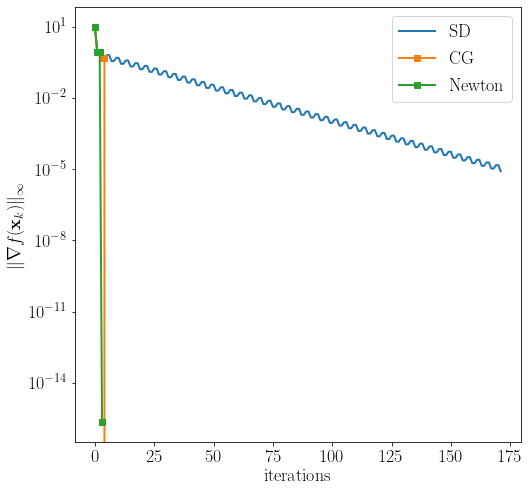

In [170]:
plt.figure(figsize=(8,8))
plt.semilogy(np.arange(len(res_sd)), np.array(res_sd), label='SD')
plt.semilogy(np.arange(len(res_cg)), np.array(res_cg), marker='s', label='CG')
plt.semilogy(np.arange(len(res_n)), np.array(res_n), marker='s', label='Newton')
plt.xlabel('iterations')
plt.ylabel(r'$\|\nabla f(\mathbf{x}_k) \|_\infty$')
plt.legend()

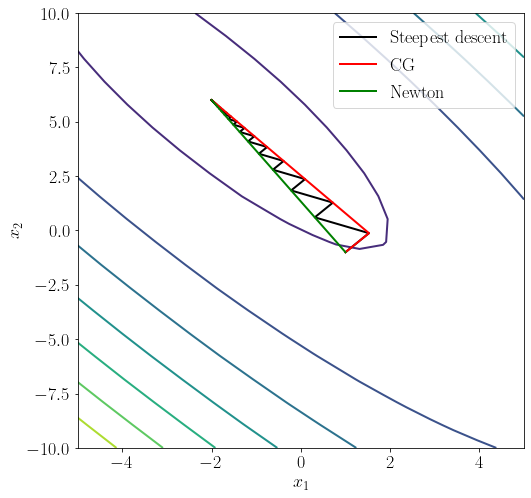

In [172]:
def fu(x):
    n = x.shape[0]
    y = np.zeros(n)
    for i in range(n):
        y[i] = 0.5 * np.dot(np.matmul(A, x[i]), x[i]) - np.dot(b, x[i])
    return y
xv, yv = np.meshgrid(np.linspace(-5,5,20), np.linspace(-10,10,20))
x = np.column_stack((xv.reshape(-1,1), yv.reshape(-1,1)))
y = fu(x)

plt.figure(figsize=(8,8))
plt.contour(xv, yv, y.reshape(20,20))
plt.plot(np.array(xk_sd)[:,0], np.array(xk_sd)[:,1], c='k', label='Steepest descent')
plt.plot(np.array(xk_cg)[:,0], np.array(xk_cg)[:,1], c='r', label='CG')
plt.plot(np.array(xk_n)[:,0], np.array(xk_n)[:,1], c='g', label='Newton')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

### 1c

In [176]:
# n=5
A = np.zeros([5,5])
for i in range(5):
    for j in range(5):
        A[i,j] = 1./ (i + j + 1) # (i+1) + (j+1) - 1
b = np.ones(5)
x0 = np.zeros(5)


exact_step_length = lambda rk, pk: - np.dot(rk, pk) / np.dot(pk, np.matmul(A, pk))
eps = 10.
xk  = x0
res_sd_n5 = []
xk_sd_n5  = []
alpha_sd_n5  = []
k = 0
func = lambda x: 1/2 * np.dot(x, np.matmul(A, x))

while eps > 1e-5 and k < 1000:
    res_sd_n5.append(eps)
    xk_sd_n5.append(xk)
    fk = func(xk)
    grad_f = np.matmul(A, xk) - b
    pk = -grad_f / np.linalg.norm(grad_f)
    rk = grad_f
    alphak = exact_step_length(rk, pk)
    xk = xk + alphak*pk
    eps = np.linalg.norm(rk, np.inf)
    res_sd_n5.append(eps)
    print(f'iter {k} alpha {alphak}, residual norm {eps}')
    alpha_sd_n5.append(alphak)
    k += 1

iter 0 alpha 1.7316814085124372, residual norm 1.0
iter 1 alpha 2.033435154899622, residual norm 0.7682851874615859
iter 2 alpha 0.8809909636182064, residual norm 0.563213473101709
iter 3 alpha 1.1292369083789537, residual norm 0.35435025575140355
iter 4 alpha 0.5255918495800991, residual norm 0.36830634966857634
iter 5 alpha 0.792157351124731, residual norm 0.19329665653070438
iter 6 alpha 0.407631856285595, residual norm 0.3272888512797898
iter 7 alpha 0.684609315491837, residual norm 0.17823093610263863
iter 8 alpha 0.3729423315224632, residual norm 0.3243187371559044
iter 9 alpha 0.6441459907812295, residual norm 0.180125704679726
iter 10 alpha 0.3559110554471697, residual norm 0.3199697088368111
iter 11 alpha 0.6176967353386683, residual norm 0.17641879464313726
iter 12 alpha 0.3421251318935324, residual norm 0.31150950209922
iter 13 alpha 0.5942535204663744, residual norm 0.17044770763266515
iter 14 alpha 0.3292773486076133, residual norm 0.30119963156470697
iter 15 alpha 0.57205

In [177]:
# n=5
A = np.zeros([5,5])
for i in range(5):
    for j in range(5):
        A[i,j] = 1./ (i + j + 1) # (i+1) + (j+1) - 1
b = np.ones(5)
x0 = np.zeros(5)


exact_step_length = lambda rk, pk: - np.dot(rk, pk) / np.dot(pk, np.matmul(A, pk))
eps = 10.
xk  = x0
res_n_n5 = []
xk_n_n5  = []
alpha_n_n5  = []
k = 0
func = lambda x: 1/2 * np.dot(x, np.matmul(A, x))

while eps > 1e-5 and k < 1000:
    res_n_n5.append(eps)
    xk_n_n5.append(xk)
    fk = func(xk)
    grad_f = np.matmul(A, xk) - b
    hess_inv = np.linalg.inv(A)
    pk = - np.matmul(hess_inv, grad_f)
    rk = grad_f
    alphak = exact_step_length(rk, pk)
    xk = xk + alphak*pk
    eps = np.linalg.norm(rk, np.inf)
    res_n_n5.append(eps)
    print(f'iter {k} alpha {alphak}, residual norm {eps}')
    alpha_sd_n5.append(alphak)
    k += 1

iter 0 alpha 1.00000000000015, residual norm 1.0
iter 1 alpha 1.000000000000565, residual norm 3.296918293926865e-12


In [178]:
# n=5
A = np.zeros([5,5])
for i in range(5):
    for j in range(5):
        A[i,j] = 1./ (i + j + 1) # (i+1) + (j+1) - 1
b = np.ones(5)
x0 = np.zeros(5)


exact_step_length = lambda rk, pk: - np.dot(rk, pk) / np.dot(pk, np.matmul(A, pk))
eps = 10.
xk  = x0
res_cg_n5 = []
xk_cg_n5  = []
alpha_cg_n5  = []
k = 0
func = lambda x: 1/2 * np.dot(x, np.matmul(A, x))

while eps > 1e-5 and k < 3000:
    res_cg_n5.append(eps)
    xk_cg_n5.append(xk)
    grad_f = np.matmul(A, xk) - b
    if k > 0:
        rk = grad_f
        betak = np.dot(pk, np.matmul(A, rk)) / np.maximum(1e-3, np.dot(pk, np.matmul(A, pk)) )
        pk = -rk + betak*pk
    else:
        pk = -grad_f   
    rk = grad_f
    alphak = exact_step_length(rk, pk)
    xk = xk + alphak*pk
    eps = np.linalg.norm(rk, np.inf)
    res_cg_n5.append(eps)
    print(f'iter {k} betak {betak}, alpha {alphak}, residual norm {eps}')
    alpha_cg_n5.append(alphak)
    k += 1

iter 0 betak 0.0, alpha 0.7744314689612786, residual norm 1.0
iter 1 betak 0.181352136597801, alpha 4.271374558553106, residual norm 0.7682851874615859
iter 2 betak 0.0646220918596472, alpha 83.85788789537298, residual norm 0.16428356127873478
iter 3 betak 0.02150532530726643, alpha 2892.983605602937, residual norm 0.024310245381361284
iter 4 betak 0.0022485845560040753, alpha 36.91644835511965, residual norm 0.05840033916484444
iter 5 betak 0.7845641497109797, alpha 2.3295061950073808, residual norm 0.13714719900753636
iter 6 betak 1.695874710010931, alpha 1.7548455457789955, residual norm 0.110686662059301
iter 7 betak 0.043850206443703625, alpha 15.28436895435024, residual norm 0.030964745933651727
iter 8 betak 1.7582185083686392, alpha 0.7755411783080353, residual norm 0.12756515484194608
iter 9 betak 0.1333412379903159, alpha 18.383958087643762, residual norm 0.03136453312981757
iter 10 betak 0.16158561607793615, alpha 3.401193039090054, residual norm 0.04559372733251621
iter 11 b

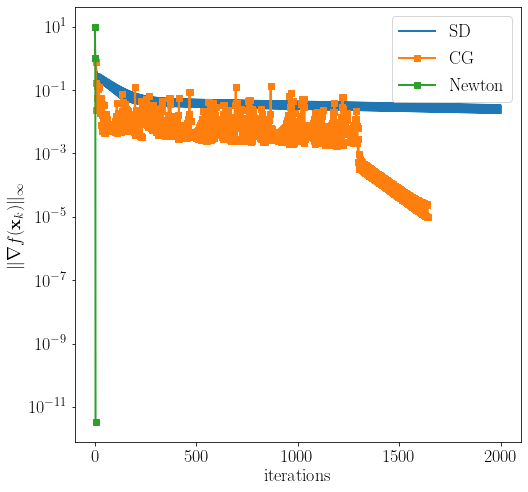

In [179]:
plt.figure(figsize=(8,8))
plt.semilogy(np.arange(len(res_sd_n5)), np.array(res_sd_n5), label='SD')
plt.semilogy(np.arange(len(res_cg_n5)), np.array(res_cg_n5), marker='s', label='CG')
plt.semilogy(np.arange(len(res_n_n5)), np.array(res_n_n5), marker='s', label='Newton')
plt.xlabel('iterations')
plt.ylabel(r'$\|\nabla f(\mathbf{x}_k) \|_\infty$')
plt.legend()

## Fletcher-Reeves

In [180]:
branin = lambda x: (x[...,1] - 5.1/4/jnp.pi**2 * x[...,0]**2 + 5/jnp.pi * x[...,0] - 6)**2 + 10*(1 - 1/8/jnp.pi)*jnp.cos(x[...,0]) + 10
x0    = np.array([[6., 10.0]])
g_inf = 10
eps   = 1e-5
k     = 0
xk    = x0 
alpha = .2
func  = branin
bounds= bounds_branin
fk    = func(xk)
ginf_fr = []
xk_fr   = []

np.set_printoptions(precision=3)
print(f'starting point x0: {xk}, f0: {fk}')
print('----------------------------------')
fres = 10

gk = np.asarray( grad(func)(xk.squeeze()) )
pk = -gk
ncalls = 1
while g_inf >= eps and np.abs(fres) >= 1e-12: # included the second condition just for convenience; feel free to remove it
    fres = -fk
    sl = Step_Length(func, xk, pk)
    alpha = sl.line_search()
    xk_1 = xk + alpha * pk
    xk_1 = project_x(xk_1, bounds)
    gk_1 = np.asarray(grad(func)(xk_1.squeeze()) )
    betak_1 = np.dot(gk_1, gk_1) / np.dot(gk, gk)
    pk_1 = -gk_1 + betak_1 * pk
    fk = func(xk_1)    
    fres = fk + fres
    g_inf = np.linalg.norm(gk_1, ord=np.inf)
    xk = xk_1
    gk = gk_1
    pk = pk_1    
    k += 1
    print(f'iteration {k}, nfcalls: {ncalls + 1}, alpha: {alpha:1.7f}, xk: {xk.squeeze()}, fk: {fk.item():2.6f}, gradient norm: {g_inf:2.6f}')
    ginf_fr.append(g_inf)
    xk_fr.append(xk)

starting point x0: [[ 6. 10.]], f0: [98.406]
----------------------------------
iteration 1, nfcalls: 2, alpha: 0.4294521, xk: [4.532 2.357], fk: 9.115784, gradient norm: 10.217072
iteration 2, nfcalls: 2, alpha: 0.1196204, xk: [3.176 1.439], fk: 1.058630, gradient norm: 1.618905
iteration 3, nfcalls: 2, alpha: 0.3999368, xk: [3.398 1.988], fk: 0.721786, gradient norm: 2.302269
iteration 4, nfcalls: 2, alpha: 0.1947474, xk: [3.117 2.436], fk: 0.420783, gradient norm: 0.282430
iteration 5, nfcalls: 2, alpha: 0.7348805, xk: [3.113 2.253], fk: 0.403854, gradient norm: 0.347151
iteration 6, nfcalls: 2, alpha: 0.1472629, xk: [3.162 2.208], fk: 0.402572, gradient norm: 0.121884
iteration 7, nfcalls: 2, alpha: 0.3553772, xk: [3.143 2.222], fk: 0.400558, gradient norm: 0.103212
iteration 8, nfcalls: 2, alpha: 0.2800453, xk: [3.153 2.258], fk: 0.398536, gradient norm: 0.093358
iteration 9, nfcalls: 2, alpha: 0.2605677, xk: [3.134 2.282], fk: 0.398193, gradient norm: 0.075381
iteration 10, nfcal

## Polyak Rebiere

In [181]:
x0    = np.array([[6., 10.0]])
g_inf = 10
eps   = 1e-5
k     = 0
xk    = x0 
alpha = .2
func  = branin
bounds= bounds_branin
fk    = func(xk)
ginf_pr = []
xk_pr   = []

np.set_printoptions(precision=3)
print(f'starting point x0: {xk}, f0: {fk}')
print('----------------------------------')
fres = 10

gk = np.asarray(grad(func)(xk.squeeze()) )
pk = -gk
ncalls = 1
while g_inf >= eps and np.abs(fres) >= 1e-12:
    fres = -fk
    sl = Step_Length(func, xk, pk)
    alpha = sl.line_search()
    xk_1 = xk + alpha * pk
    gk_1 = np.asarray(grad(func)(xk_1.squeeze()) )
    betak_1 = np.dot(gk_1, gk_1 - gk) / np.dot(gk, gk)
    pk_1 = -gk_1 + betak_1 * pk
    xk = project_x(xk, bounds)
    fk = func(xk_1)    
    fres = fk + fres
    g_inf = np.linalg.norm(gk_1, ord=np.inf)
    xk = xk_1
    gk = gk_1
    pk = pk_1    
    k += 1
    print(f'iteration {k}, nfcalls: {ncalls + 1}, alpha: {alpha:1.7f}, xk: {xk.squeeze()}, fk: {fk.item():2.6f}, gradient norm: {g_inf:2.6f}')
    ginf_pr.append(g_inf)
    xk_pr.append(xk)

starting point x0: [[ 6. 10.]], f0: [98.406]
----------------------------------
iteration 1, nfcalls: 2, alpha: 0.4482807, xk: [4.467 2.022], fk: 7.978510, gradient norm: 9.799875
iteration 2, nfcalls: 2, alpha: 0.1031386, xk: [3.409 1.661], fk: 0.911694, gradient norm: 1.952974
iteration 3, nfcalls: 2, alpha: 0.5589305, xk: [3.127 2.4  ], fk: 0.411746, gradient norm: 0.226360
iteration 4, nfcalls: 2, alpha: 0.4482906, xk: [3.102 2.321], fk: 0.405515, gradient norm: 0.353515
iteration 5, nfcalls: 2, alpha: 0.2182878, xk: [3.15  2.218], fk: 0.400799, gradient norm: 0.102111
iteration 6, nfcalls: 2, alpha: 0.3658785, xk: [3.158 2.238], fk: 0.399824, gradient norm: 0.124817
iteration 7, nfcalls: 2, alpha: 0.3665860, xk: [3.124 2.281], fk: 0.399414, gradient norm: 0.179630
iteration 8, nfcalls: 2, alpha: 0.0000278, xk: [3.124 2.281], fk: 0.399413, gradient norm: 0.179645
iteration 9, nfcalls: 2, alpha: 0.1036124, xk: [3.143 2.283], fk: 0.397970, gradient norm: 0.024184
iteration 10, nfcall

## Hestenes Stiefel

In [202]:
x0    = np.array([[6., 10.0]])
g_inf = 10
eps   = 1e-5
k     = 0
xk    = x0 
alpha = .2
func  = branin
bounds= bounds_branin
fk    = func(xk)
ginf_hs = []
xk_hs   = []

np.set_printoptions(precision=3)
print(f'starting point x0: {xk}, f0: {fk}')
print('----------------------------------')
fres = 10

gk = np.asarray(grad(func)(xk.squeeze()) )
pk = -gk
ncalls = 1
while g_inf >= eps and np.abs(fres) >= 1e-8:
    fres = -fk   
    sl = Step_Length(func, xk, pk)
    alpha = sl.line_search()    
    xk_1 = xk + alpha * pk
    gk_1 = np.asarray(grad(func)(xk_1.squeeze()) )
    betak_1 = np.dot(gk_1, gk_1 - gk) / np.maximum(1e-3, np.dot(gk_1 - gk, pk) )
    pk_1 = -gk_1 + betak_1 * pk
    xk_1 = project_x(xk_1, bounds)
    fk = func(xk_1)    
    fres = fk + fres
    g_inf = np.linalg.norm(gk_1, ord=np.inf)
    xk = xk_1
    gk = gk_1
    pk = pk_1    
    k += 1
    print(f'iteration {k}, nfcalls: {ncalls + 1}, alpha: {alpha:1.7f}, xk: {xk.squeeze()}, bk: {betak_1}, fk: {fk.item():2.6f}, gradient norm: {g_inf:2.6f}')
    ginf_hs.append(g_inf)
    xk_hs.append(xk)

starting point x0: [[ 6. 10.]], f0: [98.406]
----------------------------------
iteration 1, nfcalls: 2, alpha: 0.4270951, xk: [4.54  2.399], bk: 0.1533766652344602, fk: 9.277088, gradient norm: 10.264788
iteration 2, nfcalls: 2, alpha: 0.1687746, xk: [2.719 1.614], bk: 0.5228837213313645, fk: 2.271105, gradient norm: 5.741405
iteration 3, nfcalls: 2, alpha: 0.0000001, xk: [2.719 1.614], bk: 0.0, fk: 2.271105, gradient norm: 5.741405
iteration 4, nfcalls: 2, alpha: 0.1376690, xk: [3.509 1.893], bk: 0.5293006096179713, fk: 1.052846, gradient norm: 3.298021
iteration 5, nfcalls: 2, alpha: 0.3713549, xk: [3.413 2.375], bk: -0.32616014757246536, fk: 0.841387, gradient norm: 3.005347
iteration 6, nfcalls: 2, alpha: 0.1365234, xk: [3.014 2.235], bk: 0.4811781619530803, fk: 0.495439, gradient norm: 1.447749
iteration 7, nfcalls: 2, alpha: 0.0165673, xk: [3.015 2.231], bk: -0.8285512497369452, fk: 0.495429, gradient norm: 1.445809
iteration 8, nfcalls: 2, alpha: 0.1053941, xk: [3.164 2.28 ], b

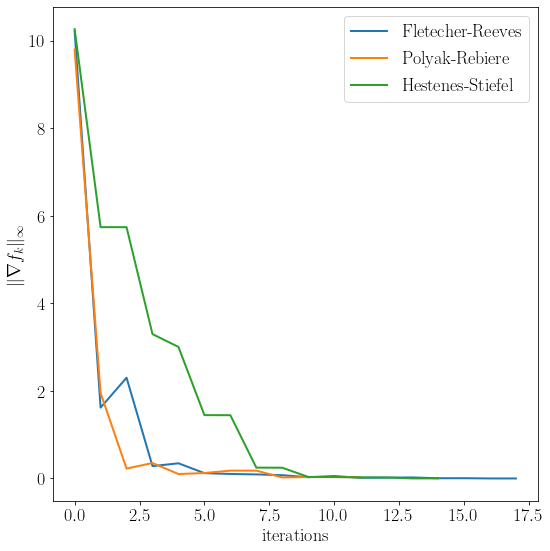

In [203]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(len(ginf_fr)), np.array(ginf_fr), label='Fletecher-Reeves')#, marker='s')
plt.plot(np.arange(len(ginf_pr)), np.array(ginf_pr), label='Polyak-Rebiere')#, marker='s')
plt.plot(np.arange(len(ginf_hs)), np.array(ginf_hs), label='Hestenes-Stiefel')#, marker='s')
plt.legend()
plt.xlabel(r'iterations')
plt.ylabel(r'$\|\nabla f_k\|_\infty$')
plt.tight_layout()

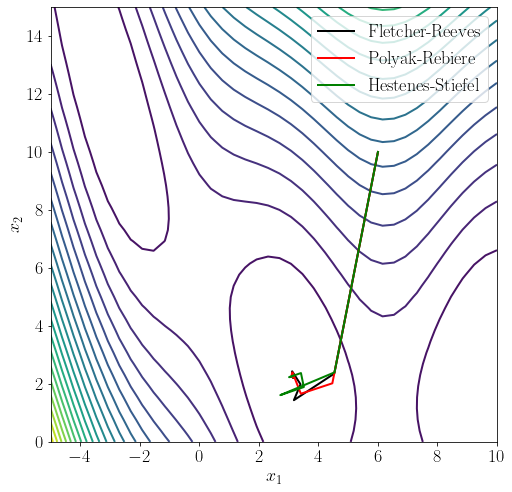

In [237]:
xv, yv = np.meshgrid(np.linspace(-5,10, m), np.linspace(0,15,m))
x = np.column_stack((xv.reshape(-1,1), yv.reshape(-1,1)))
y = branin(x)

plt.figure(figsize=(8,8))
plt.contour(xv, yv, y.reshape(m,m), levels=20)
x_fr = np.array(xk_fr).squeeze(1)
x_fr = np.row_stack((x0.reshape(1,-1), x_fr))
plt.plot(x_fr[:,0], x_fr[:,1], c='k', label='Fletcher-Reeves')
x_pr = np.array(xk_pr).squeeze(1)
x_pr = np.row_stack((x0.reshape(1,-1), x_pr))
plt.plot(x_pr[:,0], x_pr[:,1], c='r', label='Polyak-Rebiere')
x_hs = np.array(xk_hs).squeeze(1)
x_hs = np.row_stack((x0.reshape(1,-1), x_hs))
plt.plot(x_hs[:,0], x_hs[:,1], c='g', label='Hestenes-Stiefel')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()

## Nelder-Mead

In [229]:
branin = lambda x: np.asarray( np.array( (x[...,1] - 5.1/4/jnp.pi**2 * x[...,0]**2 + 5/jnp.pi * x[...,0] - 6)**2 + 10*(1 - 1/8/jnp.pi)*jnp.cos(x[...,0]) + 10 ) )

rosenbrock = lambda x: 100*(x[...,1] - x[...,0]**2)**2 + (x[...,0] - 1)**2

In [230]:
def nelder_mead_step(x_sorted, f_sorted, ncalls=0):
    f_1 = func(x_t(-1))
    ncalls += 1

    if f_sorted[0] <= f_1 and f_1 < f_sorted[-2]:
        log = r"f(-1) < f_n >= f1"
        x_sorted[-1] = x_t(-1)
        f_sorted[-1] = f_1
    elif f_1 < f_sorted[0]:
        log = 'f(-1)<f_1'
        f_2 = func(x_t(-2))
        ncalls += 1

        if f_2 < f_1:
            log = 'f(-2) < f(-1), so accepting.'
            x_sorted[-1] = x_t(-2)
            f_sorted[-1] = f_2
        else:
            log = 'f(-2) >= f(-1), so accepting x_bar(-1).'
            x_sorted[-1] = x_t(-1)
            f_sorted[-1] = f_1
    
    elif f_1 >= f_sorted[-2]:
        log = 'f(-1) >= f_n'
        
        if f_1 >= f_sorted[-2] and f_1 < f_sorted[-1]:
            log = 'outside contraction...'
            f__1_2 = func(x_t(-.5))
            ncalls += 1
            
            if f__1_2 <= f_1:
                log = 'accept outer contraction point.'
                x_sorted[-1] = x_t(-.5)
                f_sorted[-1] = f__1_2
        else:
            log = 'inside contraction...'
            f_1_2 = func(x_t(.5))
            ncalls += 1
            if f_1_2 < f_sorted[-1]:
                log = 'accept inner contraction point.'
                x_sorted[-1] = x_t(.5)
                f_sorted[-1] = f_1_2

        for i in range(1, n+1):
            log = 'shrink'
            x_sorted[i] = 0.5 * (x_sorted[0] + x_sorted[i])
            f_sorted[i] = func(x_sorted[i])
            ncalls += 1
                
    x_sorted = x_sorted[f_sorted.argsort()]
    f_sorted = f_sorted[f_sorted.argsort()]
    return x_sorted, f_sorted, log, ncalls                  

In [231]:
def plot_contours(x_sorted):
    m = 40
    xv, yv = np.meshgrid(np.linspace(-5,10, m), np.linspace(0,15,m))
    x = np.column_stack((xv.reshape(-1,1), yv.reshape(-1,1)))
    plt.figure(figsize=(8,8))
    plt.contourf(xv,yv,branin(x).reshape(m,m), levels=15, cmap='rainbow')
    cp = plt.contour(xv,yv,branin(x).reshape(m,m), levels=15, colors='k')
    plt.clabel(cp, cp.levels, inline=True, fontsize=14,)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
def plot_simplex(x_sorted):
    t1 = plt.Polygon(x_sorted[:3,:],  fc="none", ec="w", lw=2)
    plt.scatter(x_sorted[:, 0], x_sorted[:, 1], s = 20, color = 'k')
    plt.gca().add_patch(t1)

Initial point x0 [ 6. 10.], f_values [14.302 20.159 98.406]
__________________________________________
iter 1, ncalls 7, xk [2.261 5.454], fk 9.610, eps 7.9927568, log message: shrink
iter 2, ncalls 9, xk [2.798 3.857], fk 2.646, eps 11.6561651, log message: f(-2) >= f(-1), so accepting x_bar(-1).
iter 3, ncalls 13, xk [2.798 3.857], fk 2.646, eps 2.9358706, log message: shrink
iter 4, ncalls 15, xk [2.633 2.39 ], fk 1.713, eps 2.5821519, log message: f(-2) < f(-1), so accepting.
iter 5, ncalls 17, xk [3.101 2.303], fk 0.406, eps 2.2401791, log message: f(-2) >= f(-1), so accepting x_bar(-1).
iter 6, ncalls 21, xk [3.101 2.303], fk 0.406, eps 0.3750315, log message: shrink
iter 7, ncalls 22, xk [3.101 2.303], fk 0.406, eps 0.2209187, log message: f(-1) < f_n >= f1
iter 8, ncalls 23, xk [3.101 2.303], fk 0.406, eps 0.1937275, log message: f(-1) < f_n >= f1
iter 9, ncalls 24, xk [3.101 2.303], fk 0.406, eps 0.1885061, log message: f(-1) < f_n >= f1
iter 10, ncalls 28, xk [3.176 2.242], f

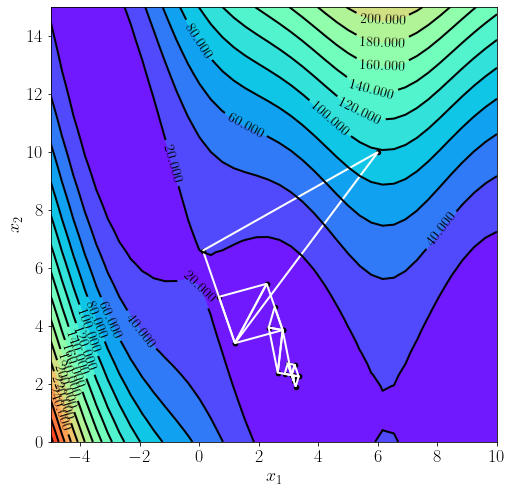

In [234]:
np.random.seed(2436)
func  = branin
bounds= bounds_branin
n = bounds.shape[-1]
# generate n+1 points
x0 = np.array([6., 10.]) 
x_set = np.random.uniform(size=[n+1, n])
x_set = bounds[0] + (bounds[1]-bounds[0]) * x_set
x_set[0] = x0
x_set = project_x(x_set, bounds)
# sort
f_x = func(x_set)
x_sorted = x_set[np.asarray(np.argsort(f_x))]
x_cent= x_sorted[:-1].mean(axis=0)
f_sorted = np.asarray(f_x[np.argsort(f_x)])
plot_contours(x_sorted)
plot_simplex(x_sorted)
fk_nm = []
eps = 10.
eps_nm = []

# secant
x_t = lambda t: x_cent + t * (x_sorted[-1] - x_cent)

print(f'Initial point x0 {x0.squeeze()}, f_values {f_sorted}')
print(f'__________________________________________')
i = 0
ncalls = n + 1 # first set of evals
calls = [ncalls]
while eps > 1e-6 and i < 1000:    
    x_sorted, f_sorted, log, ncalls = nelder_mead_step(x_sorted, f_sorted, ncalls=ncalls)
    calls.append(ncalls)
    plot_simplex(x_sorted)
    x_cent= x_sorted[:-1, :].mean(axis=0)
    x_t = lambda t: x_cent + t * (x_sorted[-1] - x_cent)
    fk_nm.append(f_sorted[0])
    eps = f_sorted[-1] - f_sorted[0]
    eps_nm.append(eps)
    print(f'iter {i+1}, ncalls {ncalls}, xk {x_sorted[0]}, fk {f_sorted[0]:2.3f}, eps {eps:2.7f}, log message: {log}')
    i += 1

### Steepest descent

In [47]:
branin_ = lambda x: (x[...,1] - 5.1/4/jnp.pi**2 * x[...,0]**2 + 5/jnp.pi * x[...,0] - 6)**2 + 10*(1 - 1/8/jnp.pi)*jnp.cos(x[...,0]) + 10 

rosenbrock = lambda x: 100*(x[...,1] - x[...,0]**2)**2 + (x[...,0] - 1)**2

In [215]:
x0    = np.array([[6., 10.]])
g_inf = 10
eps   = 1e-5
k     = 0
xk    = x0 
alpha = .2
func  = branin_
bounds= bounds_branin
fk    = func(xk)
ginf_sd_b = []
xk_sd_b   = []

np.set_printoptions(precision=3)
print(f'starting point x0: {xk}, f0: {fk}')
print('----------------------------------')
fres = 10

ncalls_sd_b = []
while g_inf >= eps and np.abs(fres) >= 1e-8:
    fres = -fk
    gk = np.asarray(grad(func)(xk.squeeze()) )
    pk = -gk/np.linalg.norm(gk)
    sl = Step_Length(func, xk, pk)
    alpha = sl.line_search()
    xk = xk + alpha * pk
    xk = project_x(xk, bounds)
    fk = func(xk)    
    fres = fk + fres
    g_inf = np.linalg.norm(gk, ord=np.inf)
    k += 1
    ncalls_sd_b.append(sl.ncalls + 1)
    print(f'iteration {k}, nfcalls: {sl.ncalls + 1}, alpha: {alpha:1.7f}, xk: {xk.squeeze()}, fk: {fk.item():2.6f}, gradient norm: {g_inf:2.6f}')
    ginf_sd_b.append(g_inf)
    xk_sd_b.append(xk)

starting point x0: [[ 6. 10.]], f0: [98.406]
----------------------------------
iteration 1, nfcalls: 12, alpha: 9.9185502, xk: [4.129 0.26 ], fk: 6.591200, gradient norm: 17.797308
iteration 2, nfcalls: 11, alpha: 1.2608915, xk: [2.965 0.745], fk: 3.340666, gradient norm: 6.574534
iteration 3, nfcalls: 8, alpha: 0.9944062, xk: [3.76  1.343], fk: 2.425087, gradient norm: 4.443442
iteration 4, nfcalls: 11, alpha: 0.8853451, xk: [2.892 1.518], fk: 1.616024, gradient norm: 4.946807
iteration 5, nfcalls: 11, alpha: 0.5069915, xk: [3.349 1.738], fk: 0.748900, gradient norm: 3.991408
iteration 6, nfcalls: 19, alpha: 0.2069238, xk: [3.167 1.835], fk: 0.577461, gradient norm: 1.423811
iteration 7, nfcalls: 17, alpha: 0.2396285, xk: [3.272 2.051], fk: 0.494636, gradient norm: 0.840425
iteration 8, nfcalls: 20, alpha: 0.2042057, xk: [3.073 2.098], fk: 0.474104, gradient norm: 1.058948
iteration 9, nfcalls: 23, alpha: 0.1114773, xk: [3.175 2.143], fk: 0.414342, gradient norm: 1.028072
iteration 1

In [217]:
x0         = np.array([[6., 10.]])
g_inf      = 10
eps        = 1e-5
k          = 0
xk         = x0 
alpha      = 1
func       = branin_
fk         = func(xk)
bounds     = bounds_branin
ginf_n_b   = []
xk_n_b     = []
fres       = 10.
ncalls_n_b     = []

np.set_printoptions(precision=3)
print(f'starting point x0: {xk}, f0: {fk}')
print('----------------------------------')

while g_inf >= eps and np.abs(fres) >= 1e-8:
    fres = -fk
    gk = np.asarray(grad(func)(xk.squeeze()) )
    Bk = np.asarray(hessian(func)(xk.squeeze()) )
    pk = -np.matmul(np.linalg.inv(Bk), gk)
    sl = Step_Length(func, xk, pk)
    alpha = sl.line_search()
    xk = xk + alpha * pk
    xk = project_x(xk, bounds)
    fk = func(xk)
    fres = fk + fres
    g_inf = np.linalg.norm(gk, ord=jnp.inf)
    k += 1
    ncalls_n_b.append(sl.ncalls + 1)
    print(f'iteration {k}, nfcalls: {sl.ncalls + 1}, alpha: {alpha:1.8f}, xk: {xk.squeeze()}, fk: {fk.item():2.3f}, gradient norm: {g_inf:2.6f}')
    ginf_n_b.append(g_inf)
    xk_n_b.append(xk)

starting point x0: [[ 6. 10.]], f0: [98.406]
----------------------------------
iteration 1, nfcalls: 11, alpha: 1.54671901, xk: [6.3 0. ], fk: 20.812, gradient norm: 17.797308
iteration 2, nfcalls: 11, alpha: 1.75313176, xk: [6.268 1.928], fk: 20.288, gradient norm: 2.201168
iteration 3, nfcalls: 8, alpha: 1.24633734, xk: [6.286 0.896], fk: 19.644, gradient norm: 1.657508
iteration 4, nfcalls: 16, alpha: 1.06064276, xk: [6.283 1.112], fk: 19.602, gradient norm: 0.408388
iteration 5, nfcalls: 8, alpha: 1.36042330, xk: [6.283 1.096], fk: 19.602, gradient norm: 0.024763
iteration 6, nfcalls: 11, alpha: 1.70407212, xk: [6.283 1.103], fk: 19.602, gradient norm: 0.008926
iteration 7, nfcalls: 5, alpha: 1.70956395, xk: [6.283 1.098], fk: 19.602, gradient norm: 0.006286
iteration 8, nfcalls: 5, alpha: 0.90113249, xk: [6.283 1.1  ], fk: 19.602, gradient norm: 0.004459
iteration 9, nfcalls: 78, alpha: 0.00000021, xk: [6.283 1.1  ], fk: 19.602, gradient norm: 0.000442


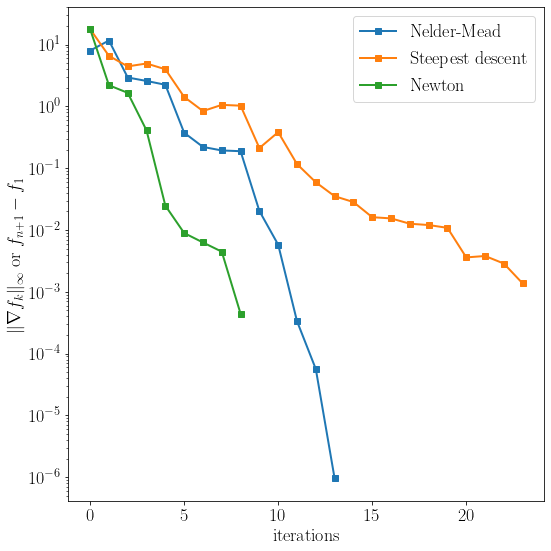

In [238]:
plt.figure(figsize=(8,8))
plt.semilogy(np.arange(len(eps_nm)), np.array(eps_nm), label='Nelder-Mead', marker='s')
plt.plot(np.arange(len(ginf_sd_b)), np.array(ginf_sd_b), label='Steepest descent', marker='s')
plt.plot(np.arange(len(ginf_n_b)), np.array(ginf_n_b), label='Newton', marker='s')
plt.legend()
plt.xlabel(r'iterations')
plt.ylabel(r'$\|\nabla f_k\|_\infty$' + ' or $f_{n+1} - f_1$')
plt.tight_layout()

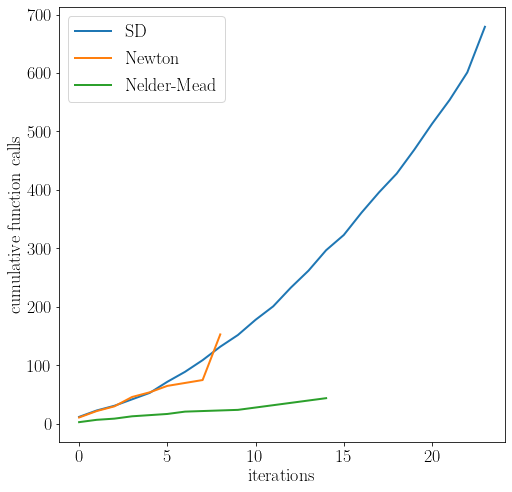

In [239]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(len(ncalls_sd_b) ), np.cumsum(np.array(ncalls_sd_b)), label='SD' )
plt.plot(np.arange(len(ncalls_n_b) ), np.cumsum(np.array(ncalls_n_b)), label='Newton' )
plt.plot(np.arange(len(calls) ), np.array(calls), label='Nelder-Mead' )
plt.ylabel('cumulative function calls')
plt.xlabel('iterations')
plt.legend()